In [1]:
import json
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import random

In [2]:
artifacts_dir = Path("/home/bunne/projects/dataset_weighting_nn/artifacts")

In [5]:
# 1. Load dataset statistics from meta.json files
print("=" * 80)
print("DATASET STATISTICS")
print("=" * 80)

dataset_stats = {}
for dataset in ["openimages", "hypersim", "gta_sfm", "scannetpp"]:
    meta_path = artifacts_dir / "embeddings" / dataset / "meta.json"
    if meta_path.exists():
        with open(meta_path, 'r') as f:
            meta = json.load(f)
            dataset_stats[dataset] = meta
            print(f"\n{dataset.upper():<15}")
            print(f"  Count:      {meta['count']:,}")
            print(f"  Root path:  {meta['root']}")

DATASET STATISTICS

OPENIMAGES     
  Count:      100
  Root path:  /globalwork/bunne/data/openimgs2

HYPERSIM       
  Count:      457
  Root path:  /globaldata/__scratch__/piekenbrinck/waifu/hypersim

GTA_SFM        
  Count:      200
  Root path:  /globaldata/GTA-SfM/data/gta_sfm_clean/train

SCANNETPP      
  Count:      1,006
  Root path:  /globaldata/scannetpp/data


In [6]:
# 2. Load and display weight aggregation results
weights_dir = artifacts_dir / "weights"
print("\n" + "=" * 80)
print("WEIGHT AGGREGATION RESULTS")
print("=" * 80)

if weights_dir.exists():
    # Load weights
    with open(weights_dir / "weights.json", 'r') as f:
        weights = json.load(f)
    
    # Load counts
    with open(weights_dir / "counts.json", 'r') as f:
        counts = json.load(f)
    
    # Load max similarities
    max_sim = np.load(weights_dir / "max_sim.npy")

    print("\nPer-dataset statistics:")
    start_idx = 0
    for dataset in ["hypersim", "gta_sfm", "scannetpp"]:
        print(f"\n{dataset.upper():<15}")
        print(f"  Weight:           {weights.get(dataset, 0):.4f}")
        count = counts.get(dataset, 0)
        print(f"  Sample count:     {count:,}")
        
        # Extract the portion of max_sim for this dataset
        if count > 0:
            dataset_max_sim = max_sim[start_idx:start_idx + count]
            print(f"  Max similarity:   {np.max(dataset_max_sim):.4f}")
            print(f"  Mean similarity:  {np.mean(dataset_max_sim):.4f}")
            start_idx += count


WEIGHT AGGREGATION RESULTS

Per-dataset statistics:

HYPERSIM       
  Weight:           0.2300
  Sample count:     23
  Max similarity:   0.7004
  Mean similarity:  0.2150

GTA_SFM        
  Weight:           0.2900
  Sample count:     29
  Max similarity:   0.8167
  Mean similarity:  0.2064

SCANNETPP      
  Weight:           0.4800
  Sample count:     48
  Max similarity:   0.8184
  Mean similarity:  0.2492


In [ ]:
# 3. Load retrieval statistics
print("\n" + "=" * 80)
print("RETRIEVAL STATISTICS (1-NN)")
print("=" * 80)

for dataset in ["hypersim", "gta_sfm", "scannetpp"]:
    retrieval_dir = artifacts_dir / "retrieval" / dataset
    sim_path = retrieval_dir / "nn_sim.npy"
    
    if sim_path.exists():
        similarities = np.load(sim_path)
        print(f"\n{dataset.upper():<15}")
        print(f"  Mean similarity:    {np.mean(similarities):.4f}")
        print(f"  Std similarity:     {np.std(similarities):.4f}")
        print(f"  Min similarity:     {np.min(similarities):.4f}")
        print(f"  Max similarity:     {np.max(similarities):.4f}")
        print(f"  Median similarity:  {np.median(similarities):.4f}")
        
        # Percentiles
        for p in [25, 50, 75, 90, 95]:
            print(f"  P{p} similarity:     {np.percentile(similarities, p):.4f}")


RETRIEVAL STATISTICS (1-NN)

HYPERSIM       
  Mean similarity:    0.2635
  Std similarity:     0.1445
  Min similarity:     0.0518
  Max similarity:     0.9618
  Median similarity:  0.2280
  P25 similarity:     0.1591
  P50 similarity:     0.2280
  P75 similarity:     0.3277
  P90 similarity:     0.4649
  P95 similarity:     0.5627

GTA_SFM        
  Mean similarity:    0.2041
  Std similarity:     0.1387
  Min similarity:     0.0337
  Max similarity:     0.9490
  Median similarity:  0.1621
  P25 similarity:     0.1045
  P50 similarity:     0.1621
  P75 similarity:     0.2587
  P90 similarity:     0.3939
  P95 similarity:     0.4916

SCANNETPP      
  Mean similarity:    0.3053
  Std similarity:     0.1533
  Min similarity:     0.0650
  Max similarity:     0.9725
  Median similarity:  0.2690
  P25 similarity:     0.1953
  P50 similarity:     0.2690
  P75 similarity:     0.3792
  P90 similarity:     0.5221
  P95 similarity:     0.6187



MEANINGFUL VISUALIZATIONS


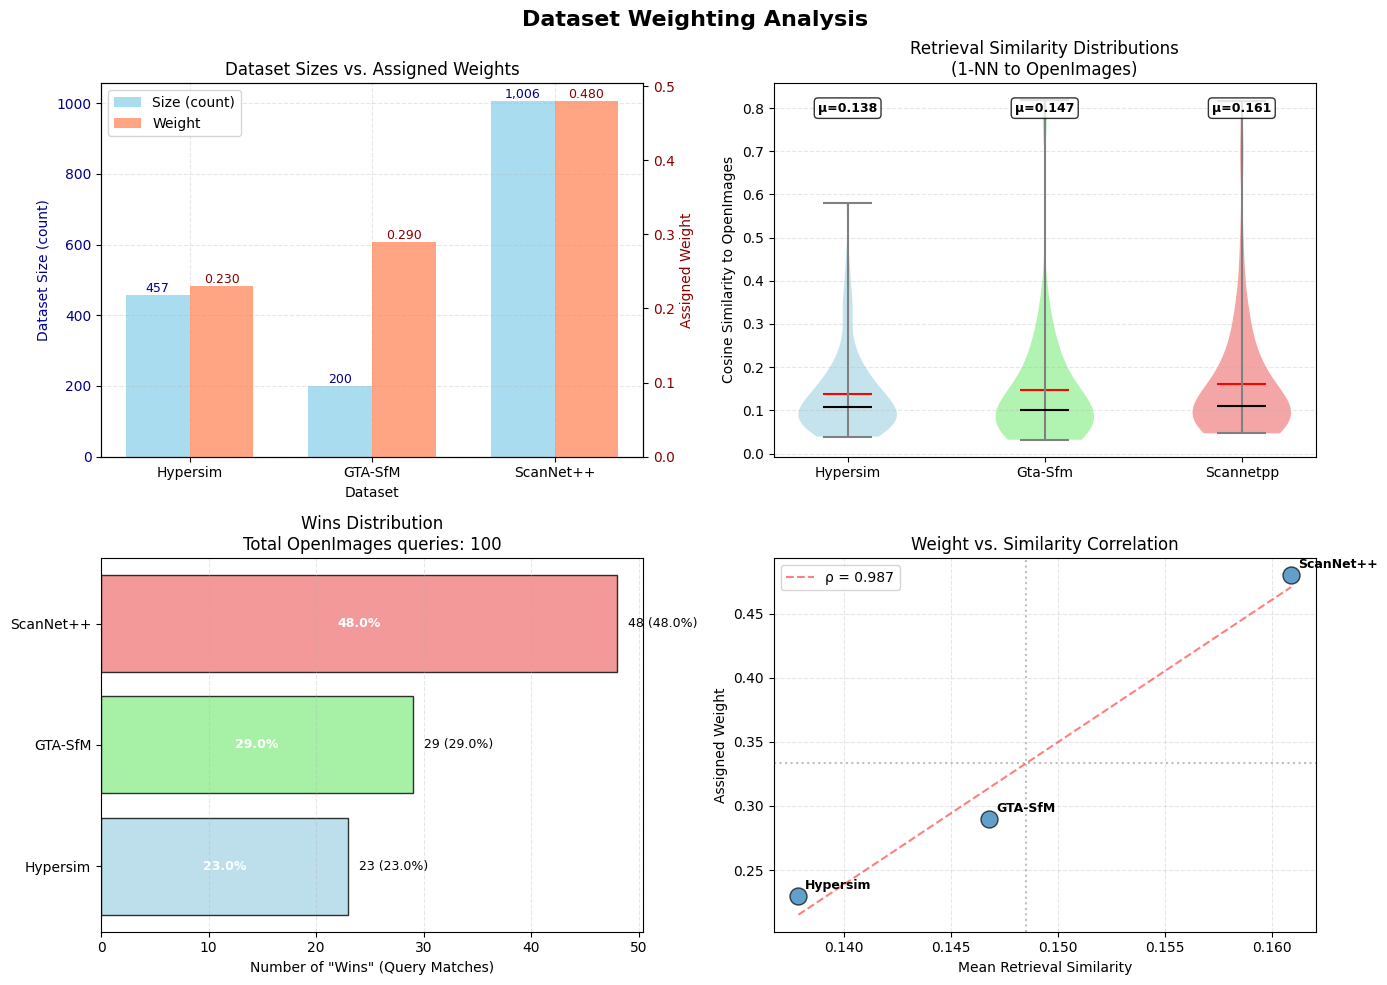


SUMMARY STATISTICS

Dataset | Size | Weight | Mean Similarity | Wins | Win %
-----------------------------------------------------------------
Hypersim         457   0.230           0.138      23    23.0%
GTA-SfM          200   0.290           0.147      29    29.0%
ScanNet++      1,006   0.480           0.161      48    48.0%


In [7]:
# 4. Visualizations - Streamlined and Meaningful
print("\n" + "=" * 80)
print("MEANINGFUL VISUALIZATIONS")
print("=" * 80)

# Pre-load only essential data
vis_data = {}
retrieval_sims = {}

# 1. Load weights data
if weights_dir.exists():
    with open(weights_dir / "weights.json", 'r') as f:
        vis_data['weights'] = json.load(f)
    
    with open(weights_dir / "counts.json", 'r') as f:
        vis_data['counts'] = json.load(f)
    
    wins_path = weights_dir / "wins.npy"
    if wins_path.exists():
        wins = np.load(wins_path)
        # Aggregate wins (0=hypersim, 1=gta_sfm, 2=scannetpp)
        unique, win_counts = np.unique(wins, return_counts=True)
        vis_data['wins_agg'] = np.zeros(3, dtype=int)
        for idx, count in zip(unique, win_counts):
            if 0 <= idx < 3:
                vis_data['wins_agg'][idx] = count
        vis_data['total_wins'] = np.sum(vis_data['wins_agg'])

# 2. Load retrieval similarities (sample for visualization)
for dataset in ["hypersim", "gta_sfm", "scannetpp"]:
    sim_path = artifacts_dir / "retrieval" / dataset / "nn_sim.npy"
    if sim_path.exists():
        all_sims = np.load(sim_path)
        # Sample max 10k points for faster plotting
        if len(all_sims) > 10000:
            indices = np.random.choice(len(all_sims), 10000, replace=False)
            retrieval_sims[dataset] = all_sims[indices]
        else:
            retrieval_sims[dataset] = all_sims

# Create a 2x2 grid for the most important visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Dataset Weighting Analysis', fontsize=16, fontweight='bold')

# --- Plot 1: Dataset Sizes vs Weights (Dual-axis) ---
ax1 = axes[0, 0]
dataset_names = ['Hypersim', 'GTA-SfM', 'ScanNet++']
dataset_keys = ['hypersim', 'gta_sfm', 'scannetpp']

# Get sizes from dataset_stats
sizes = []
for key in dataset_keys:
    if key in dataset_stats:
        sizes.append(dataset_stats[key]['count'])
    else:
        sizes.append(0)

# Get weights if available
weights_vals = []
if 'weights' in vis_data:
    for key in dataset_keys:
        weights_vals.append(vis_data['weights'].get(key, 0))

# Plot sizes
x = np.arange(len(dataset_names))
width = 0.35
bars1 = ax1.bar(x - width/2, sizes, width, color='skyblue', label='Size (count)', alpha=0.7)
ax1.set_xlabel('Dataset')
ax1.set_ylabel('Dataset Size (count)', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')
ax1.set_xticks(x)
ax1.set_xticklabels(dataset_names, rotation=0)

# Add size labels
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:,}', ha='center', va='bottom', fontsize=9,
            color='darkblue')

# Plot weights on second y-axis if available
if weights_vals:
    ax1_twin = ax1.twinx()
    bars2 = ax1_twin.bar(x + width/2, weights_vals, width, color='coral', 
                         label='Weight', alpha=0.7)
    ax1_twin.set_ylabel('Assigned Weight', color='darkred')
    ax1_twin.tick_params(axis='y', labelcolor='darkred')
    
    # Add weight labels
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax1_twin.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.3f}', ha='center', va='bottom', fontsize=9,
                     color='darkred')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax1.set_title('Dataset Sizes vs. Assigned Weights')
ax1.grid(True, alpha=0.3, linestyle='--')

# --- Plot 2: Retrieval Similarity Distributions ---
ax2 = axes[0, 1]
if retrieval_sims:
    dataset_labels = []
    similarity_data = []
    
    for key in dataset_keys:
        if key in retrieval_sims:
            similarity_data.append(retrieval_sims[key])
            dataset_labels.append(key.replace('_', '-').title())
    
    # Create violin plot
    vp = ax2.violinplot(similarity_data, showmeans=True, showmedians=True, 
                       showextrema=True)
    
    # Color the violins
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    for i, pc in enumerate(vp['bodies']):
        pc.set_facecolor(colors[i % len(colors)])
        pc.set_alpha(0.7)
    
    # Customize appearance
    vp['cmeans'].set_color('red')
    vp['cmedians'].set_color('black')
    vp['cbars'].set_color('gray')
    vp['cmins'].set_color('gray')
    vp['cmaxes'].set_color('gray')
    
    ax2.set_xticks(range(1, len(dataset_labels) + 1))
    ax2.set_xticklabels(dataset_labels, rotation=0)
    ax2.set_ylabel('Cosine Similarity to OpenImages')
    ax2.set_title('Retrieval Similarity Distributions\n(1-NN to OpenImages)')
    
    # Add mean values as text
    for i, data in enumerate(similarity_data):
        mean_val = np.mean(data)
        ax2.text(i + 1, ax2.get_ylim()[1] * 0.95, f'μ={mean_val:.3f}', 
                ha='center', va='top', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax2.grid(True, alpha=0.3, linestyle='--', axis='y')
else:
    ax2.text(0.5, 0.5, 'Retrieval data not available', 
            ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Retrieval Similarities')

# --- Plot 3: Wins Distribution ---
ax3 = axes[1, 0]
if 'wins_agg' in vis_data:
    win_counts = vis_data['wins_agg']
    total_wins = vis_data['total_wins']
    
    # Create horizontal bar chart for better readability
    y_pos = np.arange(len(dataset_names))
    
    bars = ax3.barh(y_pos, win_counts, color=colors, alpha=0.8, edgecolor='black')
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(dataset_names)
    ax3.set_xlabel('Number of "Wins" (Query Matches)')
    ax3.set_title(f'Wins Distribution\nTotal OpenImages queries: {total_wins:,}')
    
    # Add count and percentage labels
    for i, (count, bar) in enumerate(zip(win_counts, bars)):
        width = bar.get_width()
        percentage = 100 * count / total_wins if total_wins > 0 else 0
        
        # Count on the right
        ax3.text(width + total_wins * 0.01, bar.get_y() + bar.get_height()/2,
                f'{count:,} ({percentage:.1f}%)', ha='left', va='center', fontsize=9)
        
        # Percentage inside bar (if wide enough)
        if width > total_wins * 0.1:
            ax3.text(width/2, bar.get_y() + bar.get_height()/2,
                    f'{percentage:.1f}%', ha='center', va='center', 
                    fontsize=9, color='white', fontweight='bold')
    
    ax3.grid(True, alpha=0.3, linestyle='--', axis='x')
else:
    ax3.text(0.5, 0.5, 'Wins data not available', 
            ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Wins Distribution')

# --- Plot 4: Weight vs Similarity Correlation ---
ax4 = axes[1, 1]
if 'weights' in vis_data and retrieval_sims:
    # Calculate mean similarities
    mean_similarities = []
    weight_values = []
    
    for key in dataset_keys:
        if key in vis_data['weights'] and key in retrieval_sims:
            weight_values.append(vis_data['weights'][key])
            mean_similarities.append(np.mean(retrieval_sims[key]))
    
    if len(weight_values) >= 2:  # Need at least 2 points for correlation
        # Scatter plot
        scatter = ax4.scatter(mean_similarities, weight_values, s=150, 
                             alpha=0.7, edgecolors='black', linewidth=1)
        
        # Add dataset labels
        for i, (sim, weight, name) in enumerate(zip(mean_similarities, weight_values, dataset_names)):
            ax4.annotate(name, (sim, weight), 
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=9, fontweight='bold')
        
        # Calculate correlation
        if len(weight_values) > 1:
            corr_coef = np.corrcoef(mean_similarities, weight_values)[0, 1]
            
            # Add regression line
            if not np.isnan(corr_coef):
                z = np.polyfit(mean_similarities, weight_values, 1)
                p = np.poly1d(z)
                x_range = np.linspace(min(mean_similarities), max(mean_similarities), 100)
                ax4.plot(x_range, p(x_range), "r--", alpha=0.5, 
                        label=f'ρ = {corr_coef:.3f}')
                ax4.legend(loc='best')
        
        ax4.set_xlabel('Mean Retrieval Similarity')
        ax4.set_ylabel('Assigned Weight')
        ax4.set_title('Weight vs. Similarity Correlation')
        ax4.grid(True, alpha=0.3, linestyle='--')
        
        # Add reference lines at dataset counts
        ax4.axhline(y=1/3, color='gray', linestyle=':', alpha=0.5, 
                   label='Equal weight (0.333)')
        ax4.axvline(x=np.mean(mean_similarities), color='gray', 
                   linestyle=':', alpha=0.5, label='Mean similarity')
    else:
        ax4.text(0.5, 0.5, 'Insufficient data\nfor correlation analysis', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Weight vs. Similarity')
else:
    ax4.text(0.5, 0.5, 'Weight/Similarity data\nnot available', 
            ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Weight vs. Similarity Correlation')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

if 'weights' in vis_data and retrieval_sims:
    print("\nDataset | Size | Weight | Mean Similarity | Wins | Win %")
    print("-" * 65)
    
    for i, key in enumerate(dataset_keys):
        name = dataset_names[i]
        size = sizes[i] if i < len(sizes) else 0
        weight = vis_data['weights'].get(key, 0)
        mean_sim = np.mean(retrieval_sims[key]) if key in retrieval_sims else 0
        wins = vis_data['wins_agg'][i] if 'wins_agg' in vis_data else 0
        win_pct = 100 * wins / total_wins if 'total_wins' in vis_data and total_wins > 0 else 0
        
        print(f"{name:<10} {size:>9,} {weight:>7.3f} {mean_sim:>15.3f} "
              f"{wins:>7,} {win_pct:>7.1f}%")

In [ ]:
# 5. Summary statistics
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)

# Calculate embedding density
openimages_count = dataset_stats.get('openimages', {}).get('count', 0)
if openimages_count > 0:
    print(f"\nReference dataset (OpenImages) has {openimages_count:,} embeddings")
    print("This provides query density of:")
    for dataset in ["hypersim", "gta_sfm", "scannetpp"]:
        if dataset in dataset_stats:
            ratio = dataset_stats[dataset]['count'] / openimages_count
            print(f"  {dataset:<15} {ratio:.3f} queries per target sample")

# Check for potential issues
print("\nPotential issues to check:")
for dataset, stats in dataset_stats.items():
    if stats['count'] == 0:
        print(f"  ⚠️  {dataset}: No embeddings found")
    if stats['dim'] != 1536:
        print(f"  ⚠️  {dataset}: Unexpected dimension {stats['dim']} (expected 1536)")

print("\n" + "=" * 80)
print("PIPELINE COMPLETE")
print("=" * 80)


SUMMARY

Reference dataset (OpenImages) has 100,008 embeddings
This provides query density of:
  hypersim        0.746 queries per target sample
  gta_sfm         0.171 queries per target sample
  scannetpp       10.609 queries per target sample

Potential issues to check:

PIPELINE COMPLETE
